In [1]:
import random
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

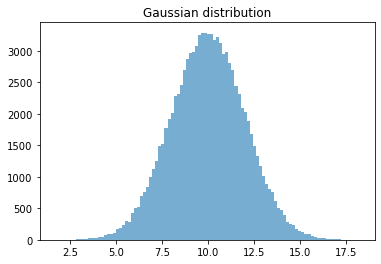

In [2]:
mu_dist = np.random.normal(10, 2, 100000)
nu_dist = np.random.gamma(7, scale = 1, size = 100000)


fig = plt.figure()
plot = plt.subplot()
plt.hist(mu_dist,100,alpha=0.6)
plt.title('Gaussian distribution')
plt.savefig('Gaussian.png')
plt.show()

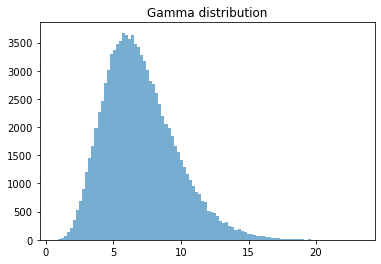

In [3]:
fig = plt.figure()
plot = plt.subplot()
plt.hist(nu_dist,100,alpha=0.6)
plt.title('Gamma distribution')
plt.savefig('Gamma.png')
plt.show()

In [4]:
##estimate the probability density function of the distributions
n_bins =50

hist_mu, edges_mu = np.histogram(mu_dist, bins=n_bins)
hist_nu, edges_nu = np.histogram(nu_dist, bins=n_bins)

##get weights of each bin
hist_mu = hist_mu/100000
hist_nu = hist_nu/100000

##remove the last bin
edges_mu = edges_mu[:-1]
edges_nu = edges_nu[:-1]

Using CVXPY to solve the Wasserstein distance

In [5]:
# the distance matrix
C = (edges_mu.reshape((n_bins,1)) - edges_nu.reshape((1,n_bins)))**2

# Variables.
a = cp.Variable((n_bins, n_bins), nonneg=True)

# Constraints.
constraints = [cp.sum(a, axis = 1) == hist_mu, 
               cp.sum(a, axis = 0) == hist_nu]

#objective.
obj = cp.trace(C.T@a)

prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve() 

print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", a.value)

status: optimal
optimal value 9.955821215539357
optimal var [[1.00000425e-05 3.49549725e-13 2.38919973e-13 ... 0.00000000e+00
  0.00000000e+00 4.33259661e-12]
 [5.00000482e-05 2.63857882e-13 9.20290801e-14 ... 0.00000000e+00
  0.00000000e+00 4.26615058e-12]
 [5.00000454e-05 4.97732051e-13 1.23097523e-13 ... 0.00000000e+00
  0.00000000e+00 4.36598288e-12]
 ...
 [4.22640642e-12 4.30779072e-12 4.39480778e-12 ... 2.00017194e-05
  9.45764576e-12 1.39303137e-11]
 [7.85524681e-12 7.93865372e-12 8.02769301e-12 ... 2.99985687e-05
  9.30980953e-10 6.15378137e-11]
 [2.44441551e-11 2.45295846e-11 2.46206463e-11 ... 2.08326463e-11
  9.99910779e-06 9.99963449e-06]]


In [18]:
##increasing bins of histogram
n_bins =100

hist_mu, edges_mu = np.histogram(mu_dist, bins=n_bins)
hist_nu, edges_nu = np.histogram(nu_dist, bins=n_bins)

##get weights of each bin
hist_mu = hist_mu/100000
hist_nu = hist_nu/100000

##remove the last bin
edges_mu = edges_mu[:-1]
edges_nu = edges_nu[:-1]

In [19]:
# the distance matrix
C = (edges_mu.reshape((n_bins,1)) - edges_nu.reshape((1,n_bins)))**2

# Variables.
a = cp.Variable((n_bins, n_bins), nonneg=True)

# Constraints.
constraints = [cp.sum(a, axis = 1) == hist_mu, 
               cp.sum(a, axis = 0) == hist_nu]

#objective.
obj = cp.trace(C.T@a)

prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve() 

print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", a.value)

status: optimal_inaccurate
optimal value 9.756654665359024
optimal var [[1.03454341e-05 9.63316255e-10 1.36395817e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.33712284e-09 3.52388391e-09 3.38595678e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.91807566e-05 2.11615248e-05 2.54968730e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.17968666e-09 6.45501864e-09 6.42333646e-09 ... 1.06270078e-05
  6.36684407e-07 1.06452984e-05]
 [9.90943573e-08 9.83705532e-08 9.83397348e-08 ... 9.22925012e-08
  9.22520201e-08 9.22100166e-08]
 [9.90510524e-08 9.83281147e-08 9.82981628e-08 ... 9.23347019e-08
  9.22951595e-08 9.22540969e-08]]


C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The CVXPY can not sovle the problem accurately with more bins of histogram.

In [8]:
## calculate 1-Wasserstein distance
from scipy.stats import wasserstein_distance

wasserstein_distance(mu_dist, nu_dist)

3.0098644938761963

Using disciplined convex programming to simulate Sinkhorn smoothing

In [21]:
maxv = np.vectorize(max)

def sinkhorn(C, mu, nu, eps, iter):
    mu = mu.reshape((C.shape[0], 1))
    nu = nu.reshape((C.shape[1], 1))
    K = np.exp(-C/eps)
    
    # initialization
    u = np.ones((C.shape[0], 1))
    v = np.ones((C.shape[1], 1))
    P = np.diag(u.flatten()) @ K @ np.diag(v.flatten())
    
    for i in range(0,iter):
        u = mu/maxv((K @ v), 1e-300) 
        v = nu/maxv((K.T @ u), 1e-300)
        P = np.diag(u.flatten()) @ K @ np.diag(v.flatten())
    
    return P, np.trace(C.T @ P)

In [20]:
P, W = sinkhorn(C, hist_mu, hist_nu, eps = 1, iter = 1000)
print(P)
print(W)

[[1.30676263e-006 2.45009734e-006 2.98936191e-006 ... 1.45427054e-208
  0.00000000e+000 8.22894817e-215]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [3.75670773e-006 8.17631704e-006 1.15802134e-005 ... 8.00447715e-202
  0.00000000e+000 6.10322601e-208]
 ...
 [6.02340518e-109 1.56266988e-105 2.63815878e-102 ... 3.21386773e-006
  0.00000000e+000 3.48180288e-006]
 [1.81813806e-112 5.08199064e-109 9.24377552e-106 ... 1.34230531e-006
  0.00000000e+000 1.68807280e-006]
 [1.55262637e-115 4.67579865e-112 9.16332671e-109 ... 1.58609771e-006
  0.00000000e+000 2.31543973e-006]]
10.23390044376834


In [14]:

P, W = sinkhorn(C, hist_mu, hist_nu, eps = 0.5, iter = 1000)
print(P)
print(W)

[[2.67521459e-006 3.76703500e-006 2.68843514e-006 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [7.16447063e-006 1.35941639e-005 1.30731357e-005 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [1.64728679e-211 4.44106683e-205 6.06826135e-199 ... 3.97696828e-006
  0.00000000e+000 3.55594263e-006]
 [3.88404638e-218 1.21553139e-211 1.92799911e-205 ... 1.79533037e-006
  0.00000000e+000 2.16308885e-006]
 [2.40386500e-224 8.73284051e-218 1.60790305e-211 ... 2.12738996e-006
  0.00000000e+000 3.45385776e-006]]
9.993794187241958


In [15]:
P, W = sinkhorn(C, hist_mu, hist_nu, eps = 0.01, iter = 1000)
print(P)
print(W)

[[0.00000000e+00 0.00000000e+00 9.88068699e-20 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
1.3562661648866703


The smaller the epsilon, the more accurate the approximation, but the smaller epsilon will cause the numerical instability of Sinkhorn's algorithm.

In [17]:
n_bins =1000

hist_mu, edges_mu = np.histogram(mu_dist, bins=n_bins)
hist_nu, edges_nu = np.histogram(nu_dist, bins=n_bins)
edges_mu = edges_mu[:-1]
edges_nu = edges_nu[:-1]
C = (edges_mu.reshape((n_bins,1)) - edges_nu.reshape((1,n_bins)))**2

##get weights of each bin
hist_mu = hist_mu/100000
hist_nu = hist_nu/100000

P, W = sinkhorn(C, hist_mu, hist_nu, eps = 1, iter = 1000)
print(P)
print(W)

[[6.47090911e-007 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.32844092e-217]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [8.78623329e-119 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 2.67468012e-006]]
10.071143791031114


Even increasing bins to 1000, Sinkhorn can also solve the problem quickly, whereas the above CVXPY will get a OOM error.